# Imaging Lunch: Introduction to PyTorch
<img style="float: right;" src="https://imaging.epfl.ch/resources/logo-for-gitlab.svg">

This notebook provides you with the basics you need to get started with PyTorch.\
It assumes that you are familiar with python and numpy and that you have a basic understanding of neural networks.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import tqdm

Tensors
=======

Tensors are very similar to numpy arrays. In fact, the API is mostly consistent as you can see in the example below.
However, they differ in two key parts:
1. they can be used for computations on different types of processing units (e.g. CPU, GPU)
2. tensors can keep track of the elements used to compute their value for auto differentiation

In [2]:
my_tensor = torch.ones(10, 5)

print(my_tensor.shape)
print(my_tensor.dtype)

my_tensor[3:6]

torch.Size([10, 5])
torch.float32


tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

## Devices

One of the big differences between `numpy` and `pytorch` is, that `pytorch` can run computation on a GPU.
Due to the amount and type of operations required for neural networks, a GPU is required for training and except for small networks even for inference.
Since transfers between the CPU and GPU memory are slow, `pytorch` requires that we explicitely tell it when it should transfer the data.

In [3]:
my_tensor.device

device(type='cpu')

In [4]:
device = torch.device("cuda:0")
my_tensor.to(device)

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], device='cuda:0')

All of the tensors involved in a computation have to be on the same device. Usually, people define a device variable at the beginning of their code (like we did in the above example) that is used throughout. This makes it easy to switch between devices.

In [5]:
my_tensor.to(device) + torch.ones(10, 5)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

## Automatic Differentiation

Instead of neural network we can start with a simple (linear) equation with two parameters $a$ and $b$ as our model:

\begin{equation}
f(x) = ax + b
\end{equation}

We would like to fit this 'model' to some data:

\begin{equation}
\{y_i, x_i\}_{i=0}^n
\end{equation}

We can define the loss function which measures the fit as the sum of squares, i.e. the square of the $\ell^2$-norm

\begin{equation}
\begin{split}
\text{loss} & = \|\mathbf{y} - f(\mathbf{x})\|_2^2 \\
& = \sum_{i=1}^{n}(y_i - f(x_i))^2 \\
& = \sum_{i=1}^{n}(y_i - ax_i - b)^2
\end{split}
\end{equation}

The partial derivatives are:

\begin{equation}
\begin{split}
\frac{\partial \text{loss}}{\partial a} & = \sum_{i=1}^{n}2(y_i - a x_i - b)(-x_i) \\
& = \sum_{i=1}^{n}2(a x_i^2 + b x_i - y_i x_i)
\end{split}
\end{equation}

\begin{equation}
\frac{\partial \text{loss}}{\partial b} = \sum_{i=1}^{n}2(a x_i + b - y_i)
\end{equation}

In [6]:
# Define some data points
x = torch.tensor([-1., 0., 1.])
y = torch.tensor([-0.2, 1, 2.2])

a = torch.tensor([1.], requires_grad=True)
b = torch.tensor([0.], requires_grad=True)

loss = torch.sum((y - a * x - b) ** 2)
# Note: normally one would use torch.nn.MSELoss(reduction='sum') but I am trying to be explicit here

loss.backward()

print(a.grad)
print(b.grad)

print(a.grad == 2 * torch.sum(a * x ** 2 + b * x - y * x))
print(b.grad == 2 * torch.sum(a * x + b - y))

tensor([-0.8000])
tensor([-6.])
tensor([True])
tensor([True])


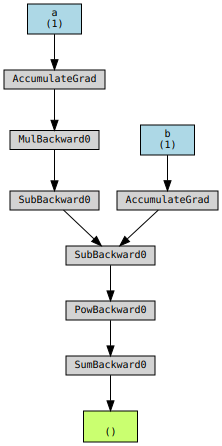

In [10]:
import torchviz
torchviz.make_dot(loss, params={"a": a, "b": b})

Detaching
---------

In some cases, for example for plotting, we need to convert a pytorch tensor to a numpy array.
Tensors that `require_grad` need to be explicitly detached before we can convert them to a numpy array.
Otherwise, we encounter the following error:

In [11]:
a = a.numpy()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [12]:
a = a.detach().numpy()

Training a Neural Network
=========================

We will start by fine tuning an existing network using what we have just learned about autograd.

In [13]:
class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)
        self.activation_function = torch.nn.Sigmoid() 

    def forward(self, img):
        res = self.conv1(img)
        res = self.activation_function(res)
        res = self.pool1(res)
        res = self.conv2(res)
        res = self.activation_function(res)
        res = self.pool2(res)
        res = torch.flatten(res, start_dim=1)
        res = self.fc1(res)
        res = self.activation_function(res)
        res = self.fc2(res)
        res = self.activation_function(res)
        res = self.fc3(res)
        return res

In [14]:
# Create an instance of the network
model = LeNet()
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (activation_function): Sigmoid()
)


In [15]:
for name, parameters in model.named_parameters():
    print(name, parameters.size())
    if "weight" in name:
        torch.nn.init.xavier_normal_(parameters)
        
total_number_of_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\nTotal number of parameters:", total_number_of_parameters)

conv1.weight torch.Size([6, 1, 5, 5])
conv1.bias torch.Size([6])
conv2.weight torch.Size([16, 6, 5, 5])
conv2.bias torch.Size([16])
fc1.weight torch.Size([120, 400])
fc1.bias torch.Size([120])
fc2.weight torch.Size([84, 120])
fc2.bias torch.Size([84])
fc3.weight torch.Size([10, 84])
fc3.bias torch.Size([10])

Total number of parameters: 61706


In [16]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(0.5, 0.5)
            ])

batch_size = 20

train_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
print("Number of image in the train dataset", len(train_dataset))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
print("number of batches", len(train_dataloader))

test_dataset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
print("\nNumber of images in the test dataset", len(test_dataset))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=6)
print("Number of batches", len(test_dataloader))

Number of image in the train dataset 60000
number of batches 3000

Number of images in the test dataset 10000
Number of batches 500


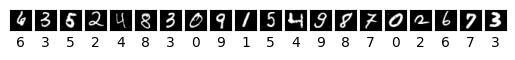

In [17]:
for data in train_dataloader:
    imgs = data[0]
    labels = data[1]
    fig, axes = plt.subplots(1, len(imgs))
    for i, img in enumerate(torch.squeeze(imgs)):
        axes[i].imshow(img, cmap="gray")
        axes[i].set_xticks([], [])
        axes[i].set_yticks([], [])
        axes[i].set_xlabel(labels[i].item())
    plt.show()
    break

In [18]:
# The optimizer defines how we update the parameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

loss_function = torch.nn.CrossEntropyLoss()

# Move the model to the device (CPU or GPU)
model.to(device)

running_losses = []

# The training loop
for epoch in range(20):
    print(f"Epoch {epoch}")
    running_loss = 0
    for data in tqdm.tqdm(train_dataloader):
        imgs = data[0].to(device)
        labels = data[1].to(device)
        # Reset the gradients
        optimizer.zero_grad()
        # Forward run through the network
        output = model(imgs)
        # Compute the loss
        loss = loss_function(output, labels)
        # Update the gradients
        loss.backward()
        # Update the parameters of the network
        optimizer.step()

        running_loss += loss.item()
    running_losses.append(running_loss)
    print("Loss", running_loss)

Epoch 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 460.38it/s]


Loss 6943.829146623611
Epoch 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 457.23it/s]


Loss 2290.9462823297363
Epoch 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 443.08it/s]


Loss 277.70932203746634
Epoch 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 455.82it/s]


Loss 196.831230383832
Epoch 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 458.05it/s]


Loss 150.52365730013116
Epoch 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 436.60it/s]


Loss 123.30021513922838
Epoch 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 468.28it/s]


Loss 105.9687583890045
Epoch 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:07<00:00, 416.48it/s]


Loss 93.88769501780916
Epoch 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 445.96it/s]


Loss 83.70820823535905
Epoch 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 440.07it/s]


Loss 68.48673745198903
Epoch 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 431.34it/s]


Loss 64.05008694522257
Epoch 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 463.73it/s]


Loss 54.7361429844932
Epoch 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 438.70it/s]


Loss 47.87388571829979
Epoch 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 448.34it/s]


Loss 40.55168384369972
Epoch 14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 447.40it/s]


Loss 34.737438329844736
Epoch 15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 445.14it/s]


Loss 28.29709634838673
Epoch 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 444.44it/s]


Loss 28.236352928126507
Epoch 17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 450.26it/s]


Loss 26.71540707363374
Epoch 18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 444.76it/s]


Loss 20.633446716975413
Epoch 19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 451.60it/s]

Loss 16.1022079487675


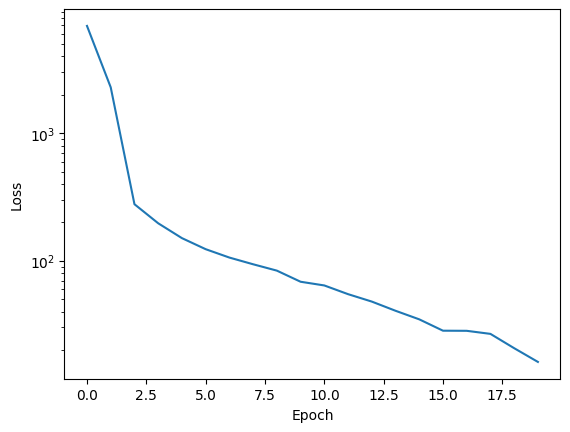

In [19]:
plt.plot(running_losses)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Test the trained model
----------------------

In [20]:
model.eval()

n_correct = 0 
for data in tqdm.tqdm(test_dataloader):
    imgs = data[0].to(device)
    labels = data[1].to(device)
    output = model(imgs)
    correct_labels = labels == output.max(dim=1).indices
    # print(correct_labels)
    # print(torch.sum(correct_labels))
    n_correct += torch.sum(correct_labels).item()
    
print(f"Correctly classified numbers in test dataset: {n_correct / len(test_dataset) * 100}%")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 736.12it/s]

Correctly classified numbers in test dataset: 99.00999999999999%


Saving a trained model
----------------------

The easiest way to save the result of your training is by saving the so called state dictionary. This contains the model parameters. However, it is important to realize that we need the model class in addition to the saved state dict to load the model.

In [21]:
# Saving model weights
torch.save(model.state_dict(), "./model_weights.pth")

# Loading model weights
new_model = LeNet()
new_model.load_state_dict(torch.load("./model_weights.pth"))

<All keys matched successfully>

Alternatively, you could use the onnx format which save all the relevant information to load the model. In fact it even allows you to execute the model in a different programming language, such as C++.

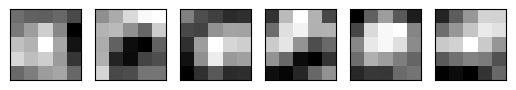

In [22]:
kernels = model.conv1.weight.detach().cpu()
fig, axes = plt.subplots(1, len(kernels))
for i in range(len(kernels)):
    axes[i].imshow(kernels[i, 0], cmap="gray")
    axes[i].set_xticks([], [])
    axes[i].set_yticks([], [])
plt.show()

Transfer learning
-----------------

In [23]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

print(model)

# Freeze all the parameters in the network
for param in model.parameters():
    param.requires_grad = False

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
total_number_of_parameters = sum(p.numel() for p in model.parameters())
print("\nTotal number of parameters:", total_number_of_parameters)

total_number_of_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\nTotal number of trainable parameters:", total_number_of_parameters)

# Replace the classifier (fully connected layer) for our task (10 instead of 1000 classes)
model.fc = torch.nn.Linear(512, 10)
torch.nn.init.xavier_normal_(model.fc.weight)

total_number_of_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\nTotal number of trainable parameters:", total_number_of_parameters)


Total number of parameters: 11689512

Total number of trainable parameters: 0

Total number of trainable parameters: 5130


In [27]:
transform = torchvision.models.ResNet18_Weights.DEFAULT.transforms()
# transform = torchvision.transforms.ToTensor()

batch_size = 200

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
print("\nNumber of images in the train dataset", len(train_dataset))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)
print("Number of batches", len(train_dataloader))

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
print("\nNumber of images in the test dataset", len(test_dataset))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)
print("Number of batches", len(test_dataloader))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Number of images in the train dataset 50000
Number of batches 250

Number of images in the test dataset 10000
Number of batches 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8431373..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.0784314].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6301525..1.8036647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5604358..2.2184873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7925336..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.1519828].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5280112..2.1

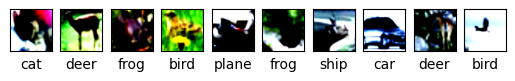

In [28]:
for data in train_dataloader:
    imgs = data[0]
    labels = data[1]
    n_images = min(10, len(imgs))
    fig, axes = plt.subplots(1, n_images)
    for i, img in enumerate(torch.squeeze(imgs)[:n_images]):
        axes[i].imshow(img.moveaxis(0,2))
        axes[i].set_xticks([], [])
        axes[i].set_yticks([], [])
        axes[i].set_xlabel(classes[labels[i].item()])
    plt.show()
    break

In [29]:
# Optimize only the classifier
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

# Move the model to the device (CPU or GPU)
model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
running_losses = []

# The training loop
for epoch in range(5):
    print(f"Epoch {epoch}")
    running_loss = 0
    for data in tqdm.tqdm(train_dataloader):
        imgs = data[0].to(device)
        labels = data[1].to(device)
        # Reset the gradients
        optimizer.zero_grad()
        # Forward run throught the network
        output = model(imgs)
        # Compute the loss
        loss = loss_function(output, labels)
        # Update the gradients
        loss.backward()
        # Update the parameters of the network
        optimizer.step()

        running_loss += loss.item()
    running_losses.append(running_loss)
    print("Loss", running_loss)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:08<00:00,  3.63it/s]


Loss 232.16638678312302
Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:10<00:00,  3.55it/s]


Loss 171.07721629738808
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:17<00:00,  3.24it/s]


Loss 162.10946601629257
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:10<00:00,  3.56it/s]


Loss 158.92664086818695
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:11<00:00,  3.49it/s]

Loss 155.8007743358612


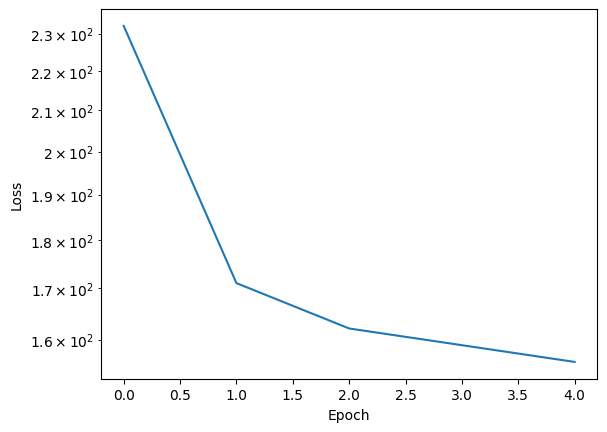

In [30]:
plt.plot(running_losses)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
model.eval()
device = torch.device("cuda:0")
model.to(device)
n_correct = 0 
for data in tqdm.tqdm(test_dataloader):
    imgs = data[0].to(device)
    labels = data[1].to(device)
    output = model(imgs)
    correct_labels = labels == output.max(dim=1).indices
    # print(correct_labels)
    # print(torch.sum(correct_labels))
    n_correct += torch.sum(correct_labels).item()
    
print(f"Correctly classified numbers in test dataset: {n_correct / len(test_dataset) * 100}%")